In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
def single_bound_diffusion(v,a,dt=1e-4,dB=1e-2):
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t

In [3]:
dt = 1e-4
dB = np.sqrt(dt)
v = 1
a = 2
N_sim = int(50e3)

In [4]:
sim_results = Parallel(n_jobs=-1)(delayed(single_bound_diffusion)(v,a,dt,dB) for _ in range(N_sim))

In [5]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


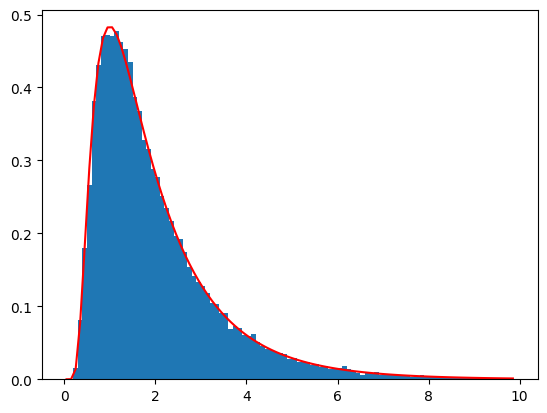

In [6]:
bin_width = 0.1
bins = np.arange(0, 10, bin_width)
plt.hist(sim_results, bins=bins, density=True);

t_pts = bins[:-1] + bin_width/2
pdf = [rho_A_t_fn(t, v, a) for t in t_pts]
plt.plot(t_pts, pdf, 'r-')

# SNLE

## proposal and prior

In [7]:
# priors and proposal
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent
import torch

# Define the distributions for "v" and "a"
v_Distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))
a_Distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))

# Group the distributions into a prior
prior = MultipleIndependent(
    [
        v_Distribution,  # Uniform distribution for "v"
        a_Distribution,  # Uniform distribution for "a"
    ],
    validate_args=False,
)

# Group the distributions into a proposal (if needed)
proposal = MultipleIndependent(
    [
        v_Distribution,  # Uniform distribution for "v"
        a_Distribution,  # Uniform distribution for "a"
    ],
    validate_args=False,
)

## simulator

In [ ]:
import torch
import numpy as np

def simulate_single_bound_diffusion(params):
    """
    Simulates single-bound diffusion for a batch of parameters.

    Args:
        params: Tensor of shape (batch_size, 2)
                - params[:, 0]: v (drift rate)
                - params[:, 1]: a (threshold)

    Returns:
        Tensor of shape (batch_size, 1) containing decision times for each parameter set.
    """
    v, a = params[:, 0], params[:, 1]  # Extract v and a
    batch_size = params.shape[0]
    dt = 1e-4
    dB = np.sqrt(dt)

    decision_times = []
    for i in range(batch_size):
        DV = 0.0  # Initialize decision variable
        t = 0.0   # Initialize time
        while True:
            DV += v[i] * dt + np.random.normal(0, dB)  # Update decision variable
            t += dt  # Increment time
            if DV >= a[i]:  # Check if threshold is crossed
                decision_times.append(t)
                break

    # Convert decision times to a tensor of shape (batch_size, 1)
    # return torch.tensor(decision_times).reshape(-1, 1)
    return np.array(decision_times)                      

## In parallel?

In [49]:
import torch

def simulate_single_bound_diffusion_parallel_2(params):
    """
    Simulates single-bound diffusion for a batch of parameters in parallel,
    ensuring the order of results matches the input.

    Args:
        params: Tensor of shape (batch_size, 2)
                - params[:, 0]: v (drift rate)
                - params[:, 1]: a (threshold)

    Returns:
        Tensor of shape (batch_size, 1) containing decision times for each parameter set.
    """
    params = params.cpu().numpy()  # Convert to NumPy for compatibility with Joblib
    
    # Attach indices to maintain order
    indexed_params = list(enumerate(params))
    
    # Process in parallel
    results = Parallel(n_jobs=-1)(
        delayed(lambda idx, v, a: (idx, single_bound_diffusion(v, a)))(idx, v, a)
        for idx, (v, a) in indexed_params
    )
    
    # Sort results by index to preserve order
    results.sort(key=lambda x: x[0])
    
    # Extract the decision times
    decision_times = [result[1] for result in results]
    
    return torch.tensor(decision_times).reshape(-1, 1)



test simulator

## test simulator by giving same param set

torch.Size([50000, 2])


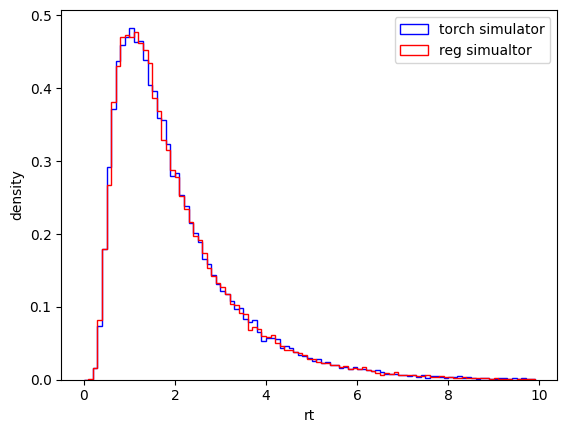

In [26]:
params = torch.tensor([v,a])
N_sim = int(50e3)
repeated_params = params.repeat(N_sim, 1)
print(repeated_params.shape)

rts = simulate_single_bound_diffusion_parallel(repeated_params)
# convert rts = numpy array
rts_np = rts.numpy()

plt.hist(rts_np, bins=bins, density=True, histtype='step', color='blue', label='torch simulator');
plt.hist(sim_results, bins=bins, density=True, label='reg simualtor', color='r', histtype='step');
plt.xlabel('rt')
plt.ylabel('density')
plt.legend()

## trainer MNLE

In [50]:
N_sim = int(500e3)

theta = proposal.sample((N_sim,))
x = simulate_single_bound_diffusion_parallel_2(theta) # 1m,10s

In [ ]:
# from sbi.inference import simulate_for_sbi
# from sbi.utils import BoxUniform

# # Define the simulator
# def simulator_single_bound(params):
#     v, a = params  # Extract parameters from the numpy array
#     DV = 0
#     t = 0
#     dt = 1e-4
#     dB = 1e-2

#     while True:
#         DV += v * dt + np.random.normal(0, dB)
#         t += dt
#         if DV >= a:
#             return np.array([t])  # Return as a numpy array for compatibility


# # Define a prior
# prior = BoxUniform(low=torch.tensor([0.1, 0.1]), high=torch.tensor([5.0, 5.0]))  # Example prior range

# # Number of simulations
# N_sim = 1000

# # Simulate using the processed simulator
# theta, x = simulate_for_sbi(
#     simulator=simulator_single_bound,
#     proposal=prior,
#     num_simulations=N_sim,
#     num_workers=32,  # Parallel execution
# )

# # Check results
# print("Simulated parameters (theta):", theta)
# print("Simulated outputs (x):", x)


In [28]:
theta.shape, x.shape

(torch.Size([500000, 2]), torch.Size([500000, 1]))

In [30]:
from sbi.inference import SNLE
from sbi.utils.get_nn_models import posterior_nn

# Define the neural network
# custom_network = posterior_nn(model="maf", hidden_features=128, num_transforms=5)

trainer = SNLE()
estimator = trainer.append_simulations(theta, x).train(training_batch_size=512)


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 45 epochs.

# likelihood

In [31]:
v = 1; a = 2
sim_results = Parallel(n_jobs=-1)(delayed(single_bound_diffusion)(v,a) for _ in range(int(50e3)))

In [32]:
bin_width = 0.1
bins = np.arange(0, 10, bin_width)
t_pts = bins[:-1] + bin_width/2

In [34]:
v, a = 1.0, 2.0  # rift rate and threshold
theta = torch.tensor([[v, a]] * len(t_pts))  # Repeat (v, a) for all t_pts

In [35]:
# Observations (t_pts as reaction times)
t_pts_tensor = torch.tensor(t_pts).reshape(-1, 1)  # Reshape to (n_samples, 1)

In [36]:
t_pts_tensor_reshaped = t_pts_tensor.unsqueeze(0)  
t_pts_tensor_reshaped.shape

torch.Size([1, 99, 1])

In [37]:
t_pts_tensor_reshaped = t_pts_tensor_reshaped.to(dtype=torch.float32)
theta = theta.to(dtype=torch.float32)

In [42]:
log_likelihood = estimator.log_prob(t_pts_tensor_reshaped, theta)


In [43]:
likelihood = torch.exp(log_likelihood)

In [44]:
# convert likelihood to numpy array
likelihood = likelihood.detach().numpy()

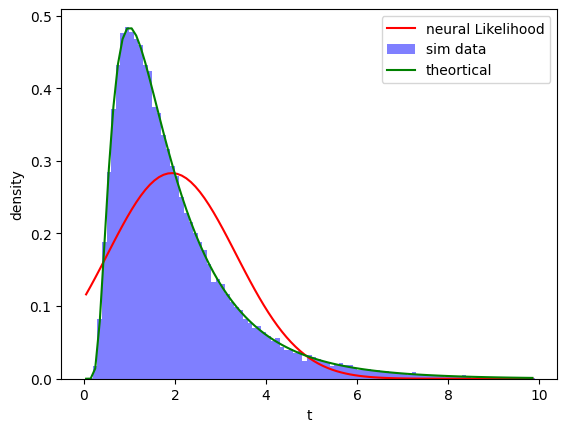

In [45]:
plt.plot(t_pts, likelihood.squeeze(), label="neural Likelihood", color='r')
plt.hist(sim_results, bins=bins, density=True, alpha=0.5, label="sim data", color='b')
plt.plot(t_pts, [rho_A_t_fn(t, v, a) for t in t_pts], label="theortical", color='g')

plt.xlabel('t')
plt.ylabel('density')
plt.legend()


In [46]:
trainer._summary.keys()

dict_keys(['epochs_trained', 'best_validation_loss', 'validation_loss', 'training_loss', 'epoch_durations_sec'])

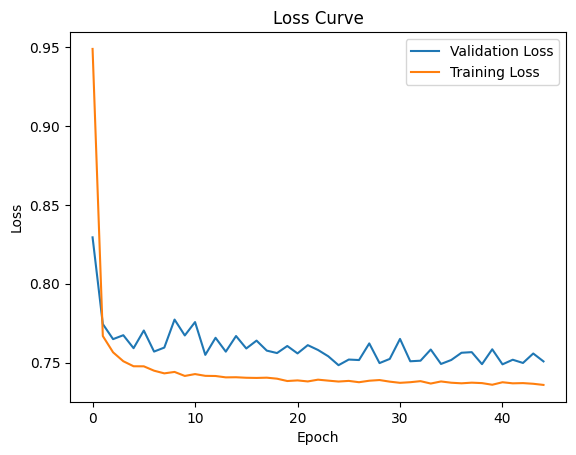

In [48]:

# Access the loss curve
loss_history = trainer._summary["validation_loss"]

# Plot the loss curve (optional)
import matplotlib.pyplot as plt

plt.plot(loss_history, label="Validation Loss")
plt.plot(trainer._summary["training_loss"], label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
